In [1]:
from torch.optim import Adam, SGD
import torch
import numpy as np
import ot
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from Util_mixture import *
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np

In [4]:
class Critic_(nn.Module):
    def __init__(self, img_dim, target_dim):
        super().__init__()
        self.crit = nn.Sequential(
        nn.Linear(img_dim + img_dim + target_dim, 256),
        nn.LeakyReLU(0.1),
        nn.Linear(256,256),
        nn.LeakyReLU(0.1),
        nn.Linear(256,256),
        nn.LeakyReLU(0.1),
        nn.Linear(256,256),
        nn.LeakyReLU(0.05),
        nn.Linear(256,1)
        )
        
    def forward(self, x, t, batch_size=64):
        x = torch.cat((x, t.view(batch_size, -1)), dim=1)
        return self.crit(x)
    
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim, target_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim + target_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256,256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, img_dim),
            nn.Sigmoid(),
        )
    def forward(self, x):
            return self.gen(x)
        
def create_GAN(mat_dim, z_dim):
    image_dim = mat_dim ** 2
    target_dim = int(mat_dim ** 2 / 4)    
    crit = Critic(image_dim, target_dim).to(device)
    gen = Generator(z_dim, image_dim, target_dim).to(device)
    
    return crit, gen

def loss_W(crit_1, crit_2, crit_3):
    return torch.mean(1/2 * (crit_1 + crit_2) - crit_3)

def loss_Drift(crit):
    return torch.mean(crit ** 2)

def loss_gp(fake1, fake2, real, rtarget, crit, batch_size):
    t = rtarget.clone().detach().requires_grad_(True)
    eps = torch.rand(1).to(device)
    XX1 = torch.cat((eps * real + (1 - eps) * fake1, eps * fake1 + (1 - eps) * fake2), dim=1)
    XX2 = torch.cat((eps * fake1 + (1 - eps) * fake1, eps * real + (1 - eps) * fake2), dim=1)
    D1 = crit(XX1, t, batch_size)
    D2 = crit(XX2, t, batch_size)

    Gamma1 = torch.autograd.grad(
        inputs=[XX1, t], 
        outputs=D1,
        grad_outputs=torch.ones_like(D1),
        create_graph=True,
        retain_graph=True)[0]
    Gamma2 = torch.autograd.grad(
        inputs=[XX2, t], 
        outputs=D2,
        grad_outputs=torch.ones_like(D2),
        create_graph=True,
        retain_graph=True)[0]
    
    Gamma = 1/2 * (Gamma1 + Gamma2)
    
    return torch.mean((torch.norm(Gamma, p=2) - 1) ** 2)

def gl(models, data_loader, opt_gen, opt_crit, z_dim, mat_dim, n_critic=10):
    
    crit = models[0]
    gen = models[1]
    for batch_id, (real, rtarget) in enumerate(data_loader()):    
        batch_size = real.shape[0]
        real = real.view(-1, mat_dim ** 2).to(device)
        rtarget = rtarget.view(-1, int(mat_dim ** 2 / 4)).to(device)

        noise1 = torch.randn(batch_size, z_dim).to(device)
        noise2 = torch.randn(batch_size, z_dim).to(device)
        noise1 = torch.cat((noise1, rtarget.view(batch_size,-1)), dim=1)
        noise2 = torch.cat((noise2, rtarget.view(batch_size,-1)), dim=1)

        fake1 = gen(noise1)
        fake2 = gen(noise2)

        inp1 = torch.cat((real, fake1), dim=1)
        inp2 = torch.cat((fake2, real), dim=1)
        inp3 = torch.cat((fake1, fake2), dim=1)

        crit1 = crit(inp1, rtarget, batch_size).view(-1)
        crit2 = crit(inp2, rtarget, batch_size).view(-1)
        crit3 = crit(inp3, rtarget, batch_size).view(-1)

        L_G = loss_W(crit1, crit2, crit3) 
        gen.zero_grad()

        L_G.backward()
        opt_gen.step()
        for _ in range(n_critic):
            noise1 = torch.randn(batch_size, z_dim).to(device)
            noise2 = torch.randn(batch_size, z_dim).to(device)

            noise1 = torch.cat((noise1, rtarget.view(batch_size,-1)), dim=1).to(device)
            noise2 = torch.cat((noise2, rtarget.view(batch_size,-1)), dim=1).to(device)

            fake1 = gen(noise1)
            fake2 = gen(noise2)

            inp1 = torch.cat((real, fake1), dim=1)
            inp2 = torch.cat((fake2, real), dim=1)
            inp3 = torch.cat((fake1, fake2), dim=1)
            inp4 = torch.cat((real, real), dim=1)

            crit1 = crit(inp1, rtarget, batch_size).view(-1)
            crit2 = crit(inp2, rtarget, batch_size).view(-1)
            crit3 = crit(inp3, rtarget, batch_size).view(-1)
            crit4 = crit(inp4, rtarget, batch_size).view(-1)
            
            a = loss_W(crit1, crit2, crit3)
            b = loss_Drift(crit4)
            c = loss_gp(fake1, fake2, real, rtarget, crit, batch_size)

            L_D = (
           -a + 1e-3 * b + 10 * c
                )

            crit.zero_grad()
            L_D.backward(retain_graph=True)
            opt_crit.step()
            
            
    return L_D.item(), -a.item(), b.item(), c.item()

In [5]:
def train(testing_ys, mat_dim, z_dim):
    
    loss_Ds, loss_Ws, loss_drifts, loss_gps = [], [], [], []
    models = create_GAN(mat_dim, z_dim)
    params  = []
    for i in range(len(models)):
        params += models[i].parameters()

    lr = 1e-5
    opt_crit = Adam(models[0].parameters(), lr=lr, betas=(0.5, 0.9), weight_decay=10e-4)
    opt_gen = Adam(models[1].parameters(), lr=lr, betas=(0.5, 0.9), weight_decay=10e-4) 

    num_epochs = 100    
    batch_size = 64    
    num_samples_per_epoch = 2048
    prog_bar = tqdm(total=num_epochs)
    for i in range(num_epochs):
        data_loader = get_epoch_data_loader_new(num_samples_per_epoch, batch_size, mat_dim)
        loss_D, loss_W, loss_drift, loss_gp = gl(models, data_loader, opt_gen, opt_crit, z_dim, mat_dim)
        loss_Ds += [loss_D]
        loss_Ws += [loss_W]
        loss_drifts += [loss_drift]
        loss_gps += [loss_gp]
        
        prog_bar.set_description('loss: {:.4f}'.format(loss_D))
        prog_bar.update()
    prog_bar.close()    

    return models, loss_Ds, loss_Ws, loss_drifts, loss_gps

In [6]:
def eval(testing_ys, mat_dim, z_dim):
    result = []
    testing_x_per_y = 2048
    weights1, weights2 = np.ones((testing_x_per_y,)) / testing_x_per_y, np.ones((testing_x_per_y,)) / testing_x_per_y

    weights1 = weights1.astype(np.float64)
    weights2 = weights2.astype(np.float64)
    w1 = 0.

    testing_num_y = len(testing_ys)
    prog_bar = tqdm(total=testing_num_y)
    prog_bar.set_description('Computing Wasserstein distances')
    for i, y in enumerate(testing_ys):
        true_posterior_samples = draw_posterior_matrix(y, mat_dim, testing_x_per_y)
        inflated_ys = y.flatten()[None, :].repeat(testing_x_per_y, 1)
        true_post = true_posterior_samples.reshape(-1, mat_dim ** 2)
        noise1 = torch.randn(testing_x_per_y, z_dim).to(device)
        rtarget = inflated_ys
        testinp = torch.cat((noise1, rtarget.view(testing_x_per_y, -1)), dim=1)

        samples1 = models[1](testinp).detach().cpu().numpy()
        samples1 = samples1.reshape(testing_x_per_y, mat_dim* mat_dim)
        result += [samples1]
        M1 = ot.dist(torch.tensor(samples1, dtype=torch.float32), true_post)
        w1 += ot.emd2(weights1, weights2, M1)
        prog_bar.set_description('W: {:.3f}'.format(w1 / (i + 1)))
        prog_bar.update()
    prog_bar.close()
    print('Wasserstein:', w1 / testing_num_y)
    return result

In [7]:
result_list = []
testing_num_y = 100
mat_dim = 8
z_dim = mat_dim

In [8]:
testing_xs = draw_x_mats(100, mat_dim)                
testing_ys = forward_mat(testing_xs)

In [9]:

models, loss_Ds, loss_Ws, loss_drifts, loss_gps = train(testing_ys, mat_dim, z_dim)


loss: -0.0069:   1%|          | 1/100 [00:06<10:58,  6.65s/it]

KeyboardInterrupt: 

In [42]:
result = eval(testing_ys, mat_dim, z_dim)

Computing Wasserstein distances:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 8, 8]) torch.Size([100, 4, 4])
4
samples: (2048, 64), true: torch.Size([2048, 64])


W: 13.918:   1%|          | 1/100 [00:02<03:28,  2.11s/it]              

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.756:   2%|▏         | 2/100 [00:04<03:27,  2.12s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.963:   3%|▎         | 3/100 [00:06<03:24,  2.11s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.938:   4%|▍         | 4/100 [00:08<03:20,  2.08s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.771:   5%|▌         | 5/100 [00:10<03:18,  2.09s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.712:   6%|▌         | 6/100 [00:12<03:15,  2.08s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.774:   7%|▋         | 7/100 [00:14<03:11,  2.06s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.569:   8%|▊         | 8/100 [00:16<03:06,  2.02s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.561:   9%|▉         | 9/100 [00:18<03:06,  2.05s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.766:  10%|█         | 10/100 [00:20<03:03,  2.04s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.729:  11%|█         | 11/100 [00:22<03:02,  2.05s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.706:  12%|█▏        | 12/100 [00:24<03:01,  2.07s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.659:  13%|█▎        | 13/100 [00:26<02:59,  2.06s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.765:  14%|█▍        | 14/100 [00:28<02:58,  2.07s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.774:  15%|█▌        | 15/100 [00:31<02:57,  2.09s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.907:  16%|█▌        | 16/100 [00:33<02:57,  2.12s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.885:  17%|█▋        | 17/100 [00:35<02:54,  2.11s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.890:  18%|█▊        | 18/100 [00:37<02:50,  2.08s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.879:  19%|█▉        | 19/100 [00:39<02:51,  2.12s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.830:  20%|██        | 20/100 [00:41<02:49,  2.11s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.770:  21%|██        | 21/100 [00:43<02:44,  2.09s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.711:  22%|██▏       | 22/100 [00:45<02:40,  2.06s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.718:  23%|██▎       | 23/100 [00:47<02:39,  2.07s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.688:  24%|██▍       | 24/100 [00:49<02:36,  2.06s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.678:  25%|██▌       | 25/100 [00:51<02:33,  2.05s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.672:  26%|██▌       | 26/100 [00:53<02:31,  2.05s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.712:  27%|██▋       | 27/100 [00:56<02:32,  2.09s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.714:  28%|██▊       | 28/100 [00:58<02:30,  2.09s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.715:  29%|██▉       | 29/100 [01:00<02:27,  2.08s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.705:  30%|███       | 30/100 [01:02<02:23,  2.05s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.702:  31%|███       | 31/100 [01:04<02:20,  2.04s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.697:  32%|███▏      | 32/100 [01:06<02:19,  2.04s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.694:  33%|███▎      | 33/100 [01:08<02:18,  2.07s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.643:  34%|███▍      | 34/100 [01:10<02:15,  2.05s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.667:  35%|███▌      | 35/100 [01:12<02:15,  2.09s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.704:  36%|███▌      | 36/100 [01:14<02:13,  2.08s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.702:  37%|███▋      | 37/100 [01:16<02:11,  2.09s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.754:  38%|███▊      | 38/100 [01:18<02:10,  2.10s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.706:  39%|███▉      | 39/100 [01:20<02:07,  2.09s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.748:  40%|████      | 40/100 [01:23<02:05,  2.09s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.726:  41%|████      | 41/100 [01:25<02:02,  2.07s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.722:  42%|████▏     | 42/100 [01:27<01:59,  2.06s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.736:  43%|████▎     | 43/100 [01:29<01:57,  2.07s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.720:  44%|████▍     | 44/100 [01:31<01:55,  2.06s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.685:  45%|████▌     | 45/100 [01:33<01:53,  2.07s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.643:  46%|████▌     | 46/100 [01:35<01:50,  2.04s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.641:  47%|████▋     | 47/100 [01:37<01:48,  2.06s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.625:  48%|████▊     | 48/100 [01:39<01:46,  2.05s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.642:  49%|████▉     | 49/100 [01:41<01:43,  2.03s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.631:  50%|█████     | 50/100 [01:43<01:41,  2.04s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.625:  51%|█████     | 51/100 [01:45<01:38,  2.02s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.671:  52%|█████▏    | 52/100 [01:47<01:38,  2.06s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.700:  53%|█████▎    | 53/100 [01:49<01:36,  2.05s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.704:  54%|█████▍    | 54/100 [01:51<01:33,  2.04s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.735:  55%|█████▌    | 55/100 [01:53<01:33,  2.08s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.700:  56%|█████▌    | 56/100 [01:55<01:30,  2.06s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.697:  57%|█████▋    | 57/100 [01:57<01:28,  2.06s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.697:  58%|█████▊    | 58/100 [02:00<01:27,  2.09s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.686:  59%|█████▉    | 59/100 [02:01<01:24,  2.05s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.706:  60%|██████    | 60/100 [02:04<01:22,  2.06s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.696:  61%|██████    | 61/100 [02:06<01:19,  2.04s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.720:  62%|██████▏   | 62/100 [02:08<01:18,  2.07s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.696:  63%|██████▎   | 63/100 [02:10<01:16,  2.06s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.699:  64%|██████▍   | 64/100 [02:12<01:13,  2.05s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.684:  65%|██████▌   | 65/100 [02:14<01:11,  2.05s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.657:  66%|██████▌   | 66/100 [02:16<01:10,  2.07s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.649:  67%|██████▋   | 67/100 [02:18<01:07,  2.05s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.642:  68%|██████▊   | 68/100 [02:20<01:05,  2.06s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.639:  69%|██████▉   | 69/100 [02:22<01:03,  2.05s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.590:  70%|███████   | 70/100 [02:24<01:00,  2.02s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.577:  71%|███████   | 71/100 [02:26<00:59,  2.06s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.597:  72%|███████▏  | 72/100 [02:28<00:58,  2.08s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.592:  73%|███████▎  | 73/100 [02:30<00:56,  2.09s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.613:  74%|███████▍  | 74/100 [02:32<00:54,  2.10s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.603:  75%|███████▌  | 75/100 [02:35<00:52,  2.09s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.636:  76%|███████▌  | 76/100 [02:37<00:50,  2.09s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.652:  77%|███████▋  | 77/100 [02:39<00:48,  2.10s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.656:  78%|███████▊  | 78/100 [02:41<00:45,  2.08s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.674:  79%|███████▉  | 79/100 [02:43<00:43,  2.08s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.690:  80%|████████  | 80/100 [02:45<00:42,  2.11s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.683:  81%|████████  | 81/100 [02:47<00:40,  2.13s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.655:  82%|████████▏ | 82/100 [02:49<00:38,  2.13s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.664:  83%|████████▎ | 83/100 [02:51<00:35,  2.11s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.677:  84%|████████▍ | 84/100 [02:54<00:33,  2.11s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.701:  85%|████████▌ | 85/100 [02:56<00:31,  2.11s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.704:  86%|████████▌ | 86/100 [02:58<00:29,  2.10s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.710:  87%|████████▋ | 87/100 [03:00<00:27,  2.09s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.686:  88%|████████▊ | 88/100 [03:02<00:24,  2.07s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.689:  89%|████████▉ | 89/100 [03:04<00:22,  2.07s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.696:  90%|█████████ | 90/100 [03:06<00:20,  2.10s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.691:  91%|█████████ | 91/100 [03:08<00:18,  2.09s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.695:  92%|█████████▏| 92/100 [03:10<00:16,  2.07s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.716:  93%|█████████▎| 93/100 [03:12<00:14,  2.09s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.724:  94%|█████████▍| 94/100 [03:14<00:12,  2.10s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.709:  95%|█████████▌| 95/100 [03:16<00:10,  2.09s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.672:  96%|█████████▌| 96/100 [03:19<00:08,  2.11s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.668:  97%|█████████▋| 97/100 [03:21<00:06,  2.14s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.688:  98%|█████████▊| 98/100 [03:23<00:04,  2.14s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.681:  99%|█████████▉| 99/100 [03:25<00:02,  2.14s/it]

samples: (2048, 64), true: torch.Size([2048, 64])


W: 14.688: 100%|██████████| 100/100 [03:27<00:00,  2.08s/it]

Wasserstein: 14.68767139754258


In [31]:
torch.save(models[1].state_dict(), r'gen_mat.pt')
torch.save(models[0].state_dict(), r'crit_mat.pt')

In [12]:
models[1].load_state_dict(torch.load(r'gen_mat.pt', map_location=torch.device('cpu')))
models[0].load_state_dict(torch.load(r'crit_mat.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

<ipython-input-15-32671eb2b24b>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  C = forward_mat(torch.tensor(A, dtype=torch.float32).reshape(1,8,8)).reshape(4,4)


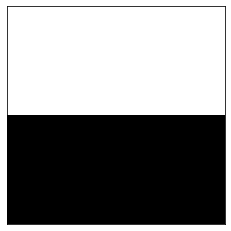

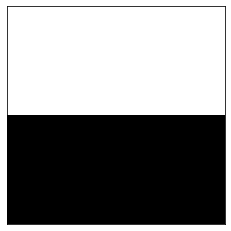

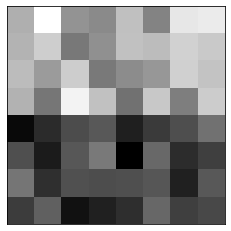

In [15]:
z = 8 * [0]
o = 8 * [1]
A = torch.tensor([o,o,o,o,z,z,z,z])
C = forward_mat(torch.tensor(A, dtype=torch.float32).reshape(1,8,8)).reshape(4,4)
plt.figure()
plt.tick_params(
    axis='both',        
    which='both',     
    bottom=False,      
    top=False,
    left=False,
    labelbottom=False,
    labelleft=False)
plt.imshow(A, cmap=plt.cm.gray)
plt.savefig('mat_x.png', bbox_inches='tight')
plt.figure()
plt.tick_params(
    axis='both',          
    which='both',     
    bottom=False,      
    top=False,
    left=False,
    labelbottom=False,
    labelleft=False)
plt.imshow(C, cmap=plt.cm.gray)
plt.savefig('mat_forward.png', bbox_inches='tight')
noise1 = torch.randn(1, z_dim)
noise = torch.cat((noise1, C.view(1,-1)), dim=1)
test = models[1].eval()
gen = test(noise)

plt.figure()
plt.tick_params(
    axis='both',   
    which='both',    
    bottom=False, 
    top=False,
    left=False,
    labelbottom=False,
    labelleft=False)
plt.imshow(gen.detach().numpy().reshape(8,8), cmap=plt.cm.gray)
plt.savefig('gen_mat.png', bbox_inches='tight')

In [ ]:
models = create_GAN()

In [67]:
sum(p.numel() for p in models[1].parameters() if p.requires_grad)

154432